# Source code

In [ ]:
!pip install -q pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00


In [ ]:
import pm4py as pm
import numpy as np
import networkx as nx
from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.petri_net.utils.petri_utils import add_place, add_transition, add_arc_from_to
from pm4py.objects.petri_net.utils.petri_utils import remove_unconnected_components
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [ ]:
def make_petri_net(matr, trans_labels, trans_names, places):
    assert len(matr) == len(places)
    assert len(matr[0]) == len(trans_names)
    assert len(trans_names) == len(trans_labels)
    petri_net = PetriNet()
    transitions_dict = dict()
    places_dict = dict()
    for t in zip(trans_names, trans_labels):
        transitions_dict[t[0]] = add_transition(petri_net, name=t[0], label=t[1])

    for p in places:
        places_dict[p] = add_place(petri_net, name=p)

    for i in range(len(matr)):
        for j in range(len(matr[i])):
            if matr[i][j] == 1:
                add_arc_from_to(places_dict[places[i]], transitions_dict[trans_names[j]], petri_net)
            elif matr[i][j] == -1:
                add_arc_from_to(transitions_dict[trans_names[j]], places_dict[places[i]], petri_net)
    return petri_net

def make_transition_matrix_v2(petri_net):
    res = dict()

    def foo(state, t, visited):
        if type(state) is PetriNet.Transition and state.label is not None:
            res[t].add(state.label)
        else:
            for a in state.out_arcs:
                if a.target.name not in visited:
                    foo(a.target, t, visited + [a.target.name])

    for t in filter(lambda t: t.label is not None, petri_net.transitions):
        res[t.label] = set()
        for a in t.out_arcs:
            foo(a.target, t.label, [t.name, a.target.name])

    return res

def gnc(tm):
    n_d = 0
    n_a = 0
    for k, v in tm.items():
        n_a += len(v)
        n_d += len(list(filter(lambda x: x[0] != k[0], v)))
    if n_a == 0:
        return 0
    return 1 - n_d / n_a

def lnc(tm):
    res = 0
    for k, v in tm.items():
        n_a = len(v)
        n_d = len(list(filter(lambda x: x[0] != k[0], v)))
        if n_a != 0:
            res += n_d / n_a
    return 1 - res / len(tm)

def blnc(tm):
    res = 0
    agents = set(map(lambda x: x[0], tm.keys()))
    for a in agents:
        agent_res = 0
        for k, v in filter(lambda x: x[0][0] == a, tm.items()):
            # print(a, k)
            n_a = len(v)
            n_d = len(list(filter(lambda x: x[0] != k[0], v)))
            if n_a != 0:
                agent_res += n_d / n_a
        # print(agent_res / len(list(filter(lambda x: x[0][0] == a, tm.items()))))
        res += agent_res / len(list(filter(lambda x: x[0][0] == a, tm.items())))
    return 1 - res / len(agents)

def make_transitions_dict(petri_net):
    d = dict()
    for t in petri_net.transitions:
        d[t.label] = t
    return d

# Random genration

In [ ]:
def _generate_petri_net_model(
        distr_in_agent_ratio,
        distr_out_agent_ratio,
        agents_num,
        agents_trans_num = [3, 3],
        agents_places_num = [3, 3],
        interaction_places_num = 2,
        none_trans_num = 0,
        ):

    total_trans = sum(agents_trans_num) + none_trans_num
    total_places = sum(agents_places_num) + interaction_places_num

    def distr_in_agent():
        u = np.random.uniform()
        if u >= distr_in_agent_ratio:
            return 0
        else:
            return np.random.choice([-1, 1])

    def distr_out_agent():
        u = np.random.uniform()
        if u >= distr_out_agent_ratio:
            return 0
        else:
            return 1

    res = np.zeros(shape=(total_places, total_trans), dtype=int)
    agent_offset_row = 0
    agent_offset_col = 0
    for i in range(agents_num):
        for row in range(agents_places_num[i]):
            for col in range(agents_trans_num[i]):
                res[row + agent_offset_row][col + agent_offset_col] = distr_in_agent()
        agent_offset_row += agents_places_num[i]
        agent_offset_col += agents_trans_num[i]

    for i in range(none_trans_num):
        pass

    for row in range(interaction_places_num):
        agent = np.random.choice([1, -1])

        for col in range(agents_trans_num[0]):
            res[row + agent_offset_row][col] = agent * distr_out_agent()
            res[row + agent_offset_row][agents_trans_num[0] + col] = -1 * agent * distr_out_agent()

    trans_labels = []
    offset = 0
    for agent_num, agent in enumerate(agents_trans_num):
        for i in range(agent):
            trans_labels.append(f'{agent_num}_{i}')
        offset = agent
    for _ in range(none_trans_num):
        trans_labels.append(None)

    trans_names = [f't_{i}' for i in range(total_trans)]
    places = [f'p_{i}' for i in range(total_places)]
    return make_petri_net(res, trans_labels, trans_names, places)

def generate_petri_net_model(**d):
    petri_net = _generate_petri_net_model(**d)
    return petri_net

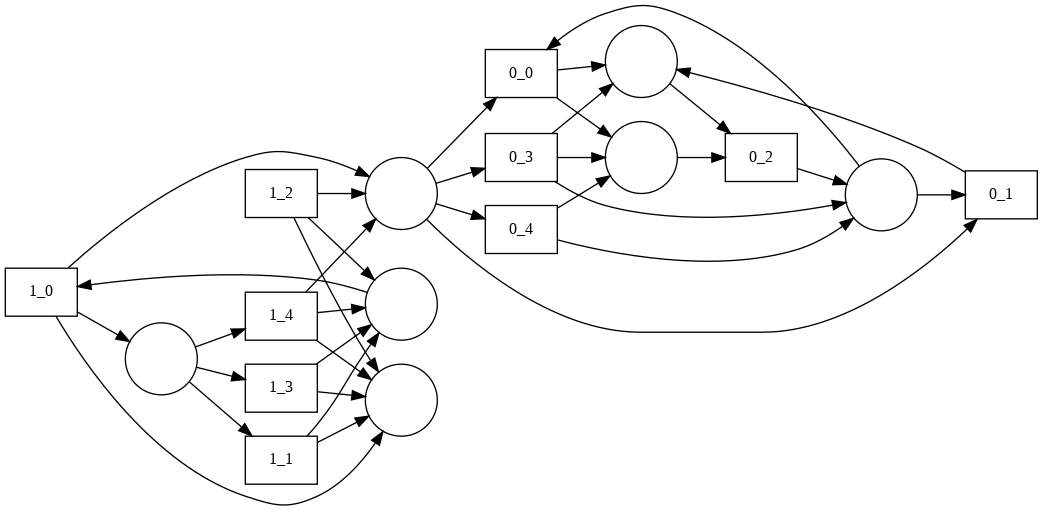

In [ ]:
petri_net = generate_petri_net_model(
    distr_in_agent_ratio=.8,
    distr_out_agent_ratio=.8,
    agents_num = 2,
    agents_trans_num = [5, 5],
    agents_places_num = [3, 3],
    interaction_places_num = 1,
    none_trans_num = 0,
)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('lnc = ', lnc(tm))
print('gnc = ', gnc(tm))
print('blnc = ', blnc(tm))

{'0_0': {'1_1', '0_3', '0_4', '0_2', '1_0', '1_2', '0_1'}, '0_1': {'1_1', '0_3', '0_0', '0_4', '0_2', '1_0', '1_2'}, '0_3': {'1_1', '0_0', '0_4', '0_2', '1_0', '1_2', '0_1'}, '0_2': {'1_1', '0_3', '0_0', '0_4', '1_0', '1_2'}, '0_4': {'1_1', '0_3', '0_0', '0_2', '1_0', '1_2', '0_1'}, '1_0': {'0_3'}, '1_1': {'0_3', '0_0', '0_2', '1_0', '1_2', '0_1'}, '1_2': {'1_1', '0_3', '1_0'}}
lnc =  0.4732142857142858
gnc =  0.5227272727272727
blnc =  0.4452380952380953


In [ ]:
from tqdm import tqdm
import pandas as pd

In [ ]:
num_of_eval = 100
p_range = range(1, 11)
t_range = range(1, 11)
a_range = range(0, 11)
agent_range = 0.5
cols = ['lnc', 'blnc', 'gnc', 'places', 'transitions', 'in_agent_ratio', 'out_agent_ratio', 'places_communication']
df = pd.DataFrame(columns=cols)

i_r = 0.8
o_r = 0.8

for a in tqdm(a_range):
    for t in t_range:
        for p in p_range:
            for i in range(num_of_eval):
                petri_net = generate_petri_net_model(
                    distr_in_agent_ratio=i_r,
                    distr_out_agent_ratio=o_r,
                    agents_num = 2,
                    agents_trans_num = [t, t],
                    agents_places_num = [p, p],
                    interaction_places_num = a,
                    none_trans_num = 0,
                )
                tm = make_transition_matrix_v2(petri_net)
                _lnc = lnc(tm)
                _gnc = gnc(tm)
                _blnc = blnc(tm)
                cur_row = pd.DataFrame.from_dict([dict(zip(cols, [_lnc, _blnc, _gnc, p, t, i_r, o_r, a]))])
                df = pd.concat([df, cur_row])


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return fn(*args, **kwargs)
100%|██████████| 11/11 [13:45<00:00, 75.05s/it]


In [ ]:
df.to_csv('data.csv')

# Experimental results

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('data.csv')
df = df.drop(columns=['Unnamed: 0', 'in_agent_ratio', 'out_agent_ratio', 'blnc'])

C:\Users\egorzem\AppData\Local\Temp\ipykernel_12180\1163709997.py:3: FutureWarning: The provided callable <function mean at 0x000002BFC5789A80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_grp = df_filtered.groupby(by=['places_communication']).agg(
C:\Users\egorzem\AppData\Local\Temp\ipykernel_12180\1163709997.py:3: FutureWarning: The provided callable <function var at 0x000002BFC5789D00> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  df_grp = df_filtered.groupby(by=['places_communication']).agg(
C:\Users\egorzem\AppData\Local\Temp\ipykernel_12180\1163709997.py:3: FutureWarning: The provided callable <function mean at 0x000002BFC5789A80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will 

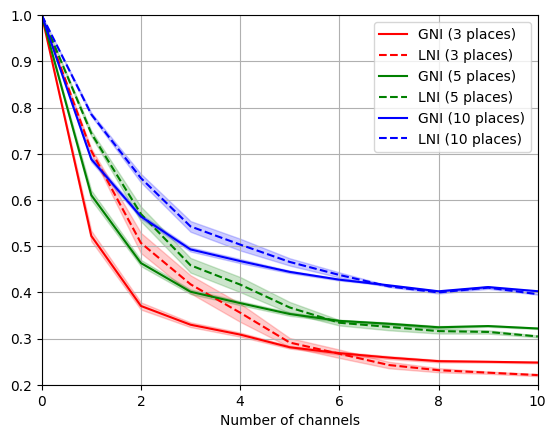

In [6]:
for p, c in zip([3, 5, 10], ['r', 'g', 'b', 'm']):
    df_filtered = df[(df['transitions'] == 5) & (df['places'] == p)]
    df_grp = df_filtered.groupby(by=['places_communication']).agg(
        lnc_avg=pd.NamedAgg(column="lnc", aggfunc=np.mean),
        gnc_avg=pd.NamedAgg(column="gnc", aggfunc=np.mean),
        lnc_var=pd.NamedAgg(column="lnc", aggfunc=np.var),
        gnc_var=pd.NamedAgg(column="gnc", aggfunc=np.var),
        ).reset_index()

    x = df_grp['places_communication']
    y = df_grp['gnc_avg']
    yerr = df_grp['gnc_var']

    plt.plot(x, y, label='GNI ({} places)'.format(p), c=c)
    plt.fill_between(x=x, y1=y-yerr, y2=y+yerr, alpha=0.2, color=c)

    x = df_grp['places_communication']
    y = df_grp['lnc_avg']
    yerr = df_grp['lnc_var']

    plt.plot(x, y, label='LNI ({} places)'.format(p), ls='--', c=c)
    plt.fill_between(x=x, y1=y-yerr, y2=y+yerr, alpha=0.2, color=c)

plt.grid(True)
plt.xlim((0, 10))
plt.ylim((.2, 1.))
plt.legend(loc='best')
# plt.title('Experiment evaluation (5 transitions)')
plt.xlabel('Number of channels')
plt.savefig('channels.png')

C:\Users\egorzem\AppData\Local\Temp\ipykernel_12180\2316110518.py:3: FutureWarning: The provided callable <function mean at 0x000002BFC5789A80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_tr_3_gr = df_tr_3.groupby(by=['places']).agg(
C:\Users\egorzem\AppData\Local\Temp\ipykernel_12180\2316110518.py:3: FutureWarning: The provided callable <function var at 0x000002BFC5789D00> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  df_tr_3_gr = df_tr_3.groupby(by=['places']).agg(
C:\Users\egorzem\AppData\Local\Temp\ipykernel_12180\2316110518.py:3: FutureWarning: The provided callable <function mean at 0x000002BFC5789A80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep cu

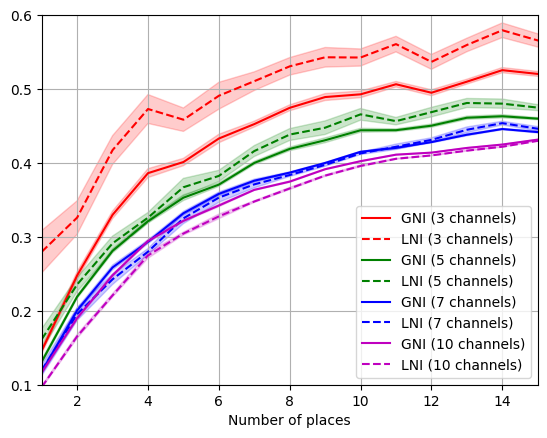

In [7]:
for p, c in zip([3, 5, 7, 10], ['r', 'g', 'b', 'm']):
    df_tr_3 = df[(df['transitions'] == 5) & (df['places_communication'] == p)]
    df_tr_3_gr = df_tr_3.groupby(by=['places']).agg(
        lnc_avg=pd.NamedAgg(column="lnc", aggfunc=np.mean),
        gnc_avg=pd.NamedAgg(column="gnc", aggfunc=np.mean),
        lnc_var=pd.NamedAgg(column="lnc", aggfunc=np.var),
        gnc_var=pd.NamedAgg(column="gnc", aggfunc=np.var),
        ).reset_index()

    x = df_tr_3_gr['places']
    y = df_tr_3_gr['gnc_avg']
    yerr = df_tr_3_gr['gnc_var']

    plt.plot(x, y, label='GNI ({} channels)'.format(p), c=c)
    plt.fill_between(x=x, y1=y-yerr, y2=y+yerr, alpha=0.2, color=c)

    x = df_tr_3_gr['places']
    y = df_tr_3_gr['lnc_avg']
    yerr = df_tr_3_gr['lnc_var']

    plt.plot(x, y, label='LNI ({} channels)'.format(p), ls='--', c=c)
    plt.fill_between(x=x, y1=y-yerr, y2=y+yerr, alpha=0.2, color=c)

plt.grid(True)
plt.xlim((1, 15))
plt.ylim((.1, .6))
plt.legend(loc='best')
plt.xlabel('Number of places')
plt.savefig('places.png')

# GW-net composition

## Example 1


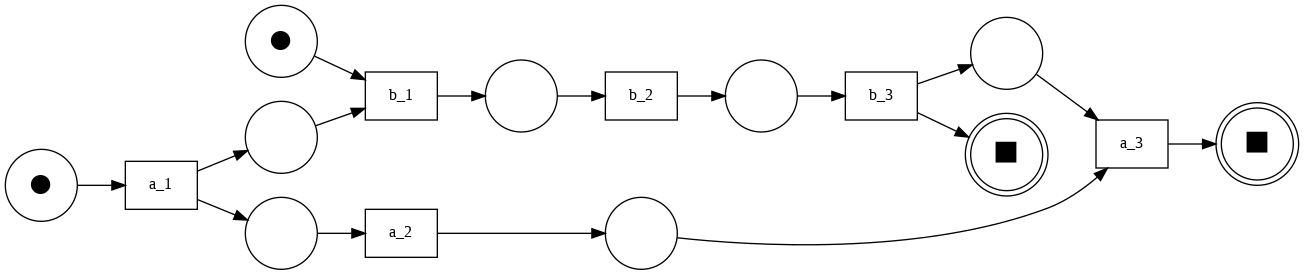

In [ ]:
matr = [
    [1, 0, 0, 0, 0, 0],
   [-1, 1, 0, 0, 0, 0],
    [0,-1, 1, 0, 0, 0],
    [0, 0, -1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0,-1, 1, 0],
    [0, 0, 0, 0,-1, 1],
    [0, 0, 0, 0, 0,-1],
   [-1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0,-1],
]
trans_labels = ['a_1', 'a_2', 'a_3', 'b_1', 'b_2', 'b_3']
trans_names = [f't_{i}' for i in range(6)]
places = [f'p_{i}' for i in range(10)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
places = sorted(list(petri_net.places), key=lambda x: int(x.name.split('_')[1]))
im = pm.objects.petri_net.obj.Marking([places[0], places[4]])
fm = pm.objects.petri_net.obj.Marking([places[3], places[7]])
pm.view_petri_net(petri_net, im, fm)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'a_2', 'b_1'}, 'b_2': {'b_3'}, 'a_3': set(), 'a_2': {'a_3'}, 'b_1': {'b_2'}, 'b_3': {'a_3'}}
gnc  =  0.6666666666666667
lnc  =  0.75
blnc =  0.75


In [ ]:
log = pm.play_out(petri_net, im, fm, )
df = pm.convert_to_dataframe(log)
df = df[df['case:concept:name'].map(int) < 1]

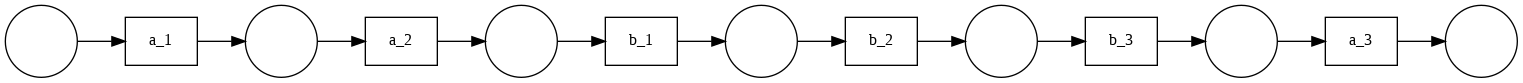

In [ ]:
pn_d, im_d, fm_d = pm.discover_petri_net_inductive(df)
pm.view_petri_net(pn_d)

In [ ]:
tm = make_transition_matrix_v2(pn_d)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

print('fitness')
print(pm.conformance.fitness_alignments(df, pn_d, im_d, fm_d,))
print('precision')
print(pm.conformance.precision_token_based_replay(df, pn_d, im_d, fm_d, case_id_key='case:concept:name'))

{'a_1': {'a_2'}, 'b_3': {'a_3'}, 'b_2': {'b_3'}, 'a_2': {'b_1'}, 'b_1': {'b_2'}, 'a_3': set()}
gnc  =  0.6
lnc  =  0.6666666666666667
blnc =  0.6666666666666667
fitness
{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0}
precision


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

1.0


a


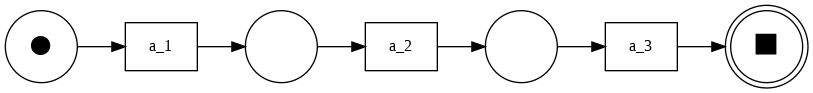

b


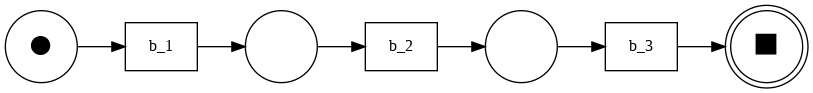

In [ ]:
d = dict()
for l in ['a', 'b']:
    print(l)
    df_l = df[df['concept:name'].str.contains(l)]
    d[l] = pm.discover_petri_net_inductive(df_l)
    pm.view_petri_net(*d[l])


In [ ]:
petri_net_ind = d['a'][0]
places_dict = dict()
transitions_dict = dict()

for p in d['b'][0].places:
    places_dict[p.name] = add_place(petri_net_ind, name=p.name)

for t in d['b'][0].transitions:
    transitions_dict[t.label] = add_transition(petri_net_ind, name=t.name, label=t.label)

for a in list(d['b'][0].arcs):
    if type(a.source) is PetriNet.Place:
        add_arc_from_to(places_dict[a.source.name], transitions_dict[a.target.label], petri_net_ind)
    else:
        add_arc_from_to(transitions_dict[a.source.label], places_dict[a.target.name], petri_net_ind)

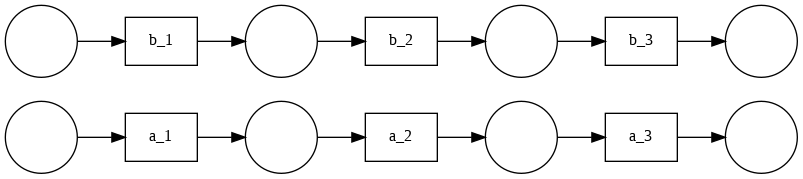

In [ ]:
pm.view_petri_net(petri_net_ind)

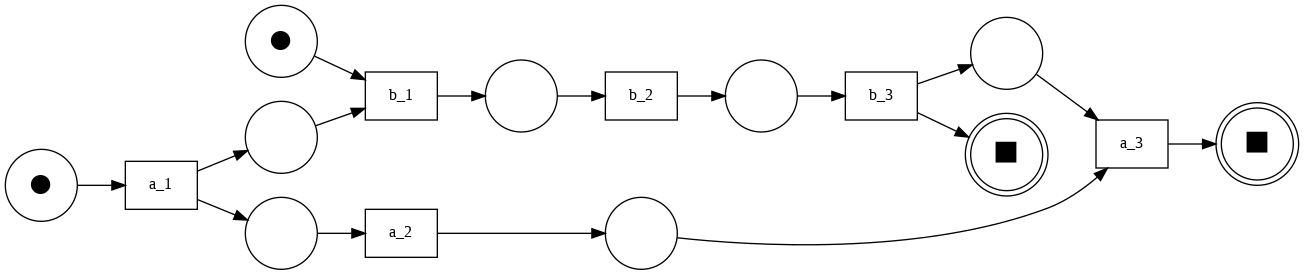

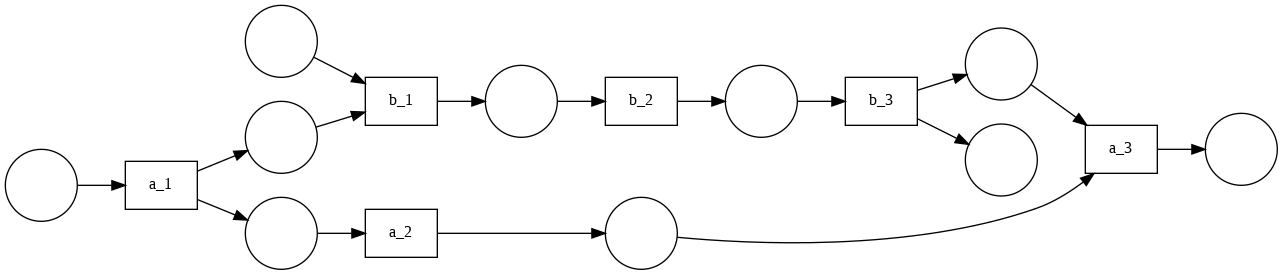

In [ ]:
t_d = make_transitions_dict(petri_net_ind)

c1 = add_place(petri_net_ind, name='c_1')
c2 = add_place(petri_net_ind, name='c_2')

add_arc_from_to(t_d['a_1'], c1, petri_net_ind)
add_arc_from_to(c1, t_d['b_1'], petri_net_ind)

add_arc_from_to(t_d['b_3'], c2, petri_net_ind)
add_arc_from_to(c2, t_d['a_3'], petri_net_ind)

im_ind = pm.objects.petri_net.obj.Marking(list(filter(lambda x: x.name == 'source', petri_net_ind.places)))
fm_ind = pm.objects.petri_net.obj.Marking(list(filter(lambda x: x.name == 'sink', petri_net_ind.places)))

pm.view_petri_net(petri_net_ind, im_ind, fm_ind)
pm.view_petri_net(petri_net_ind)

In [ ]:
cur_petri_net = (petri_net_ind, im_ind, fm_ind)

tm = make_transition_matrix_v2(cur_petri_net[0]
                               )
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

print('fitness')
print(pm.conformance.fitness_alignments(df, *cur_petri_net))
print('precision')
print(pm.conformance.precision_token_based_replay(df, *cur_petri_net))

{'a_1': {'b_1', 'a_2'}, 'a_3': set(), 'b_2': {'b_3'}, 'a_2': {'a_3'}, 'b_1': {'b_2'}, 'b_3': {'a_3'}}
gnc  =  0.6666666666666667
lnc  =  0.75
blnc =  0.75
fitness
{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0}
precision


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

0.8571428571428572


## Example 2

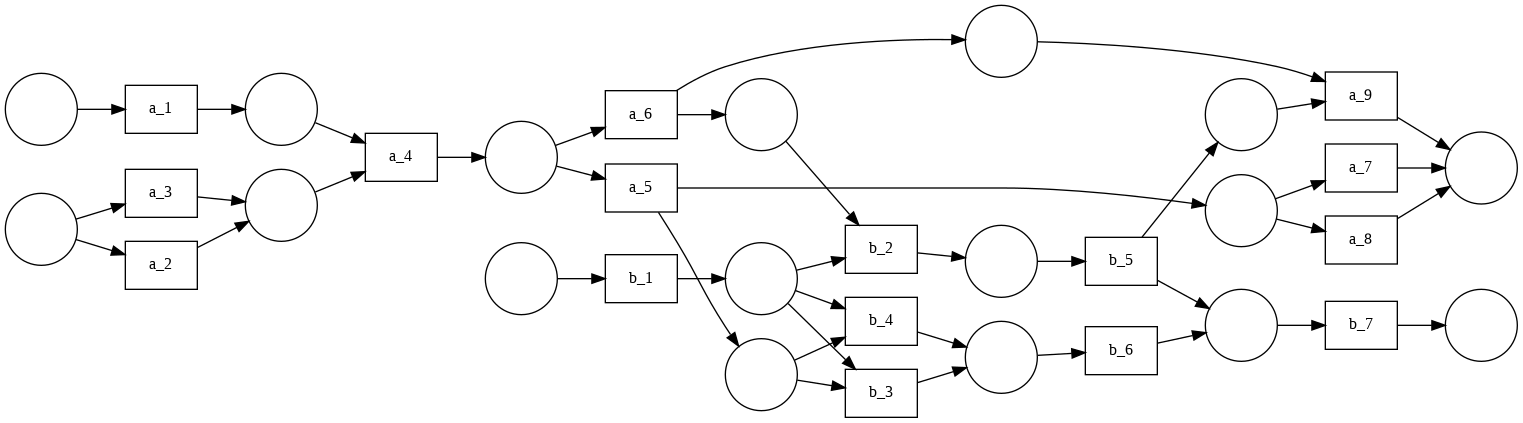

In [ ]:
matr = [
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [-1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0,-1,-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0,-1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0,-1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0],
                                #
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1],
    #1  2  3  4  5  6  7  8  9 #1  2  3  4  5  6  7
    [0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
    # [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,-1, 0, 0],

]
trans_labels = [f'a_{i}' for i in range(1, 10)] + [f'b_{i}' for i in range(1, 8)]
trans_names = [f't_{i}' for i in range(16)]
places = [f'p_{i}' for i in range(17)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'b_5': {'a_9', 'b_7'}, 'b_6': {'b_7'}, 'a_1': {'a_4'}, 'a_3': {'a_4'}, 'a_2': {'a_4'}, 'a_4': {'a_6', 'a_5'}, 'a_5': {'b_4', 'a_7', 'b_3', 'a_8'}, 'a_6': {'a_9', 'b_2'}, 'a_7': set(), 'a_8': set(), 'a_9': set(), 'b_1': {'b_4', 'b_3', 'b_2'}, 'b_2': {'b_5'}, 'b_7': set(), 'b_4': {'b_6'}, 'b_3': {'b_6'}}
gnc  =  0.8
lnc  =  0.90625
blnc =  0.9087301587301587


In [ ]:
places = sorted(list(petri_net.places), key=lambda x: int(x.name.split('_')[1]))
im = pm.objects.petri_net.obj.Marking(places[:2] + [places[8]])
fm = pm.objects.petri_net.obj.Marking([places[-4], places[7]])

In [ ]:
print('simplicity = ', pm.simplicity_petri_net(petri_net, im, fm))

simplicity =  0.7021276595744681


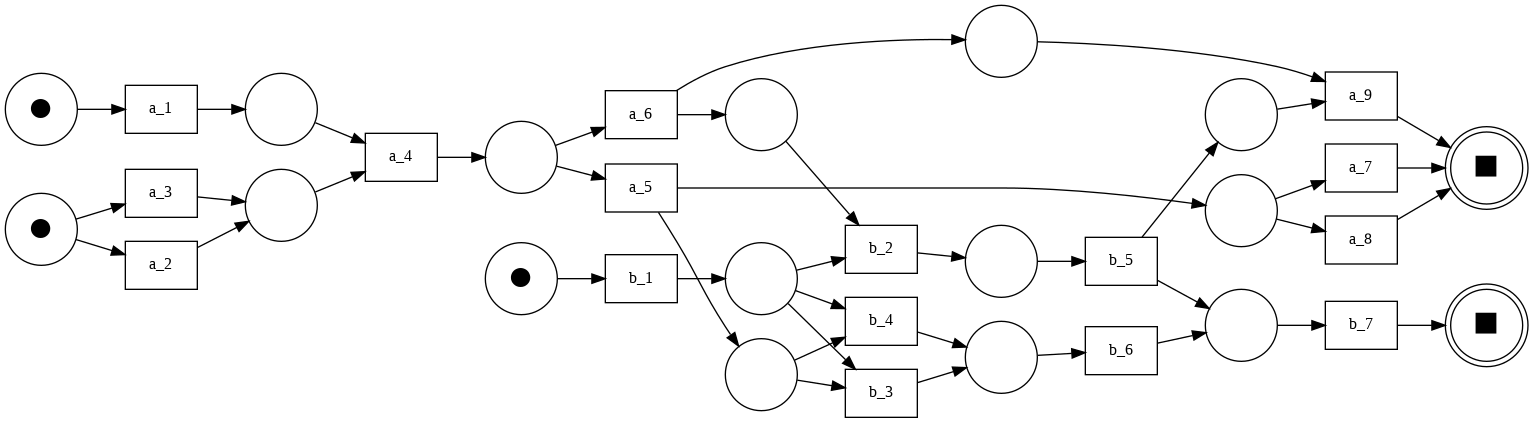

In [ ]:
pm.view_petri_net(petri_net, im, fm)

In [ ]:
log = pm.play_out(petri_net, im, fm, )
df = pm.convert_to_dataframe(log)
df = df[df['case:concept:name'].map(int) < 10]

In [ ]:
print('fitness')
print(pm.conformance.fitness_alignments(df, petri_net, im, fm))
print('precision')
print(pm.conformance.precision_token_based_replay(df, petri_net, im, fm, case_id_key='case:concept:name'))

fitness


aligning log, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0}
precision


replaying log with TBR, completed traces ::   0%|          | 0/53 [00:00<?, ?it/s]

0.7764705882352941


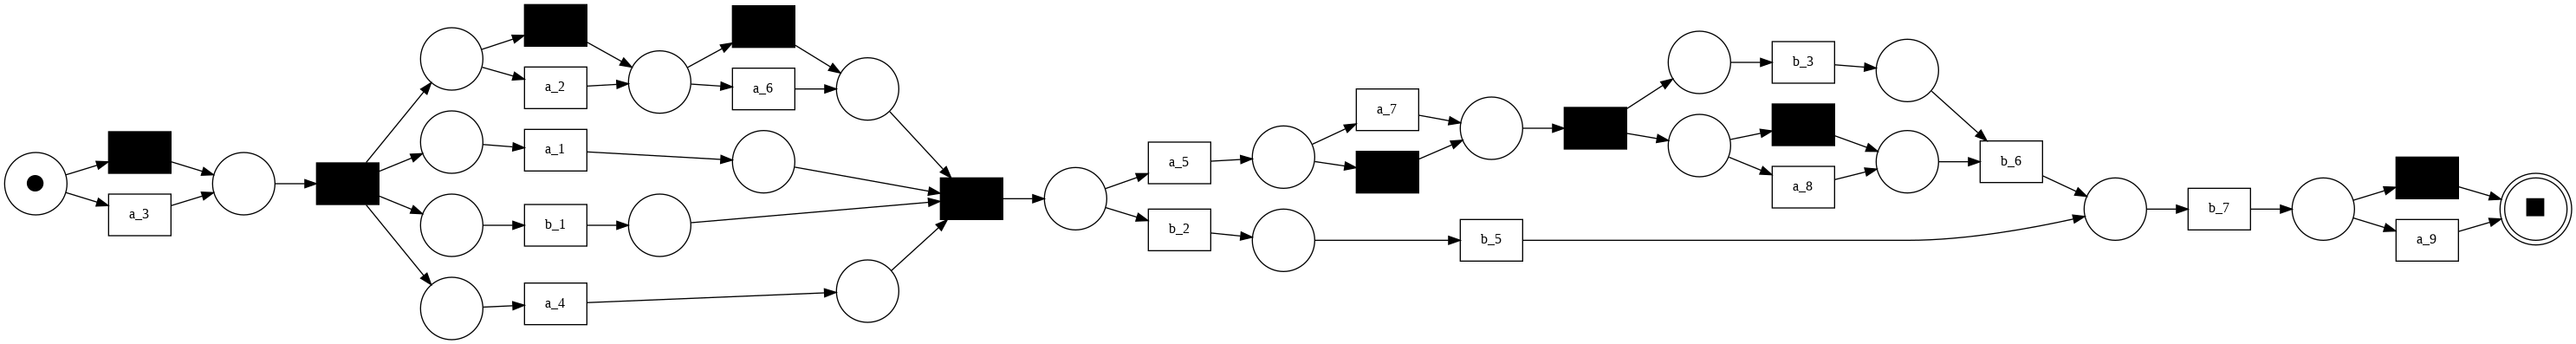

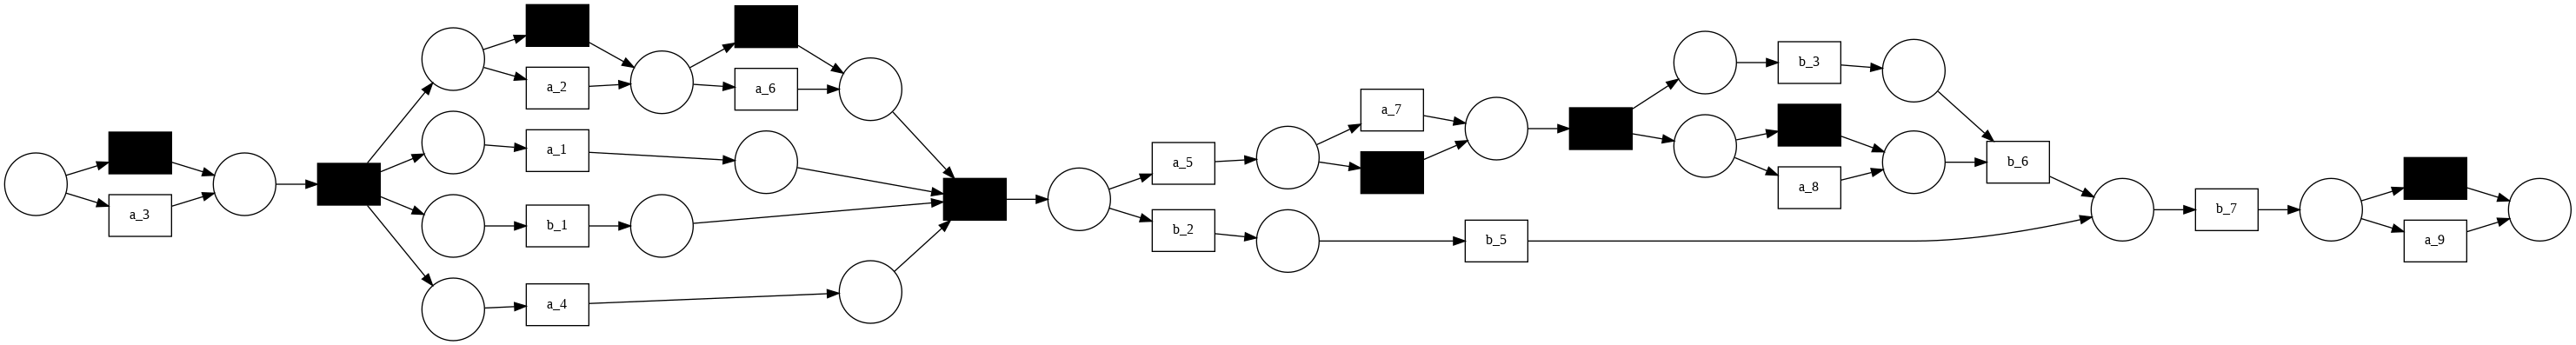

In [ ]:
pn_d, im_d, fm_d = pm.discover_petri_net_inductive(df)
pm.view_petri_net(pn_d, im_d, fm_d)
pm.view_petri_net(pn_d)

In [ ]:
tm = make_transition_matrix_v2(pn_d)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

print('fitness')
print(pm.conformance.fitness_alignments(df, pn_d, im_d, fm_d))
print('precision')
print(pm.conformance.precision_token_based_replay(df, pn_d, im_d, fm_d))

{'a_7': {'b_6', 'b_3', 'a_8'}, 'a_3': {'b_1', 'a_5', 'a_6', 'a_2', 'b_2', 'a_1', 'a_4'}, 'b_1': {'a_5', 'b_2'}, 'b_5': {'b_7'}, 'a_8': {'b_6'}, 'b_6': {'b_7'}, 'a_5': {'b_6', 'a_7', 'b_3', 'a_8'}, 'b_3': {'b_6'}, 'a_1': {'a_5', 'b_2'}, 'a_4': {'a_5', 'b_2'}, 'a_2': {'a_6', 'a_5', 'b_2'}, 'b_2': {'b_5'}, 'a_6': {'a_5', 'b_2'}, 'a_9': set(), 'b_7': {'a_9'}}
gnc  =  0.5806451612903225
lnc  =  0.6142857142857143
blnc =  0.6369047619047619
fitness


aligning log, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.999969334559951}
precision


replaying log with TBR, completed traces ::   0%|          | 0/53 [00:00<?, ?it/s]

0.534412955465587


a


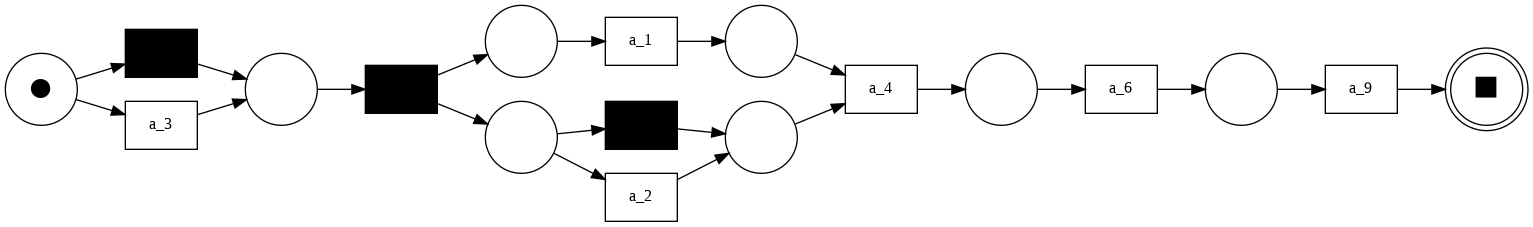

b


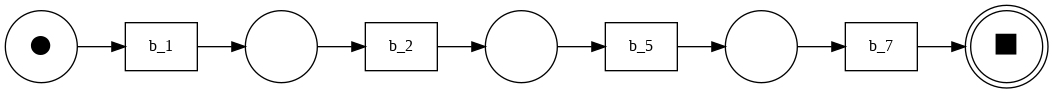

In [ ]:
d = dict()
for l in ['a', 'b']:
    print(l)
    df_l = df[df['concept:name'].str.contains(l)]
    d[l] = pm.discover_petri_net_inductive(df_l)
    pm.view_petri_net(*d[l])


In [ ]:
petri_net_ind = d['a'][0]
places_dict = dict()
transitions_dict = dict()

for p in d['b'][0].places:
    places_dict[p.name] = add_place(petri_net_ind, name=p.name)

for t in d['b'][0].transitions:
    transitions_dict[t.label] = add_transition(petri_net_ind, name=t.name, label=t.label)

for a in list(d['b'][0].arcs):
    if type(a.source) is PetriNet.Place:
        add_arc_from_to(places_dict[a.source.name], transitions_dict[a.target.label], petri_net_ind)
    else:
        add_arc_from_to(transitions_dict[a.source.label], places_dict[a.target.name], petri_net_ind)

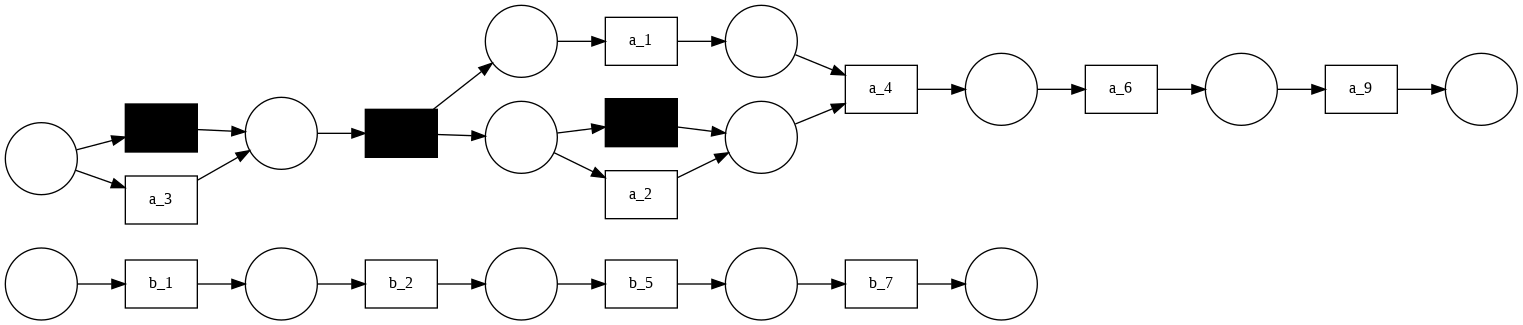

In [ ]:
pm.view_petri_net(petri_net_ind)

In [ ]:
t_d = make_transitions_dict(petri_net_ind)

c1 = add_place(petri_net_ind, name='c_1')
c2 = add_place(petri_net_ind, name='c_2')
c3 = add_place(petri_net_ind, name='c_3')

add_arc_from_to(t_d['a_6'], c1, petri_net_ind)
add_arc_from_to(c1, t_d['b_2'], petri_net_ind)

add_arc_from_to(t_d['a_5'], c2, petri_net_ind)
add_arc_from_to(c2, t_d['b_3'], petri_net_ind)
add_arc_from_to(c2, t_d['b_4'], petri_net_ind)

add_arc_from_to(t_d['b_5'], c3, petri_net_ind)
add_arc_from_to(c3, t_d['a_9'], petri_net_ind)

im_ind = pm.objects.petri_net.obj.Marking(list(filter(lambda x: x.name == 'source', petri_net_ind.places)))
fm_ind = pm.objects.petri_net.obj.Marking(list(filter(lambda x: x.name == 'sink', petri_net_ind.places)))

pm.view_petri_net(petri_net_ind, im_ind, fm_ind)
pm.view_petri_net(petri_net_ind)

KeyError: 'a_5'

In [ ]:
tm = make_transition_matrix_v2(petri_net_ind)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

print('fitness')
print(pm.conformance.fitness_alignments(df, petri_net_ind, im_ind, fm_ind))
print('precision')
print(pm.conformance.precision_token_based_replay(df, petri_net_ind, im_ind, fm_ind))

{'b_3': {'b_6'}, 'b_2': {'b_5'}, 'b_4': {'b_6'}, 'b_7': set(), 'b_5': {'a_9', 'b_7'}, 'b_6': {'b_7'}, 'a_3': {'a_4'}, 'a_1': {'a_4'}, 'a_2': {'a_4'}, 'b_1': {'b_4', 'b_3', 'b_2'}, 'a_4': {'a_6', 'a_5'}, 'a_5': {'b_4', 'a_7', 'b_3'}, 'a_7': set(), 'a_6': {'a_9', 'b_2'}, 'a_9': set()}
gnc  =  0.7894736842105263
lnc  =  0.8888888888888888
blnc =  0.8913690476190477
fitness


aligning log, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999944444753085}
precision


replaying log with TBR, completed traces ::   0%|          | 0/66 [00:00<?, ?it/s]

0.7953216374269005


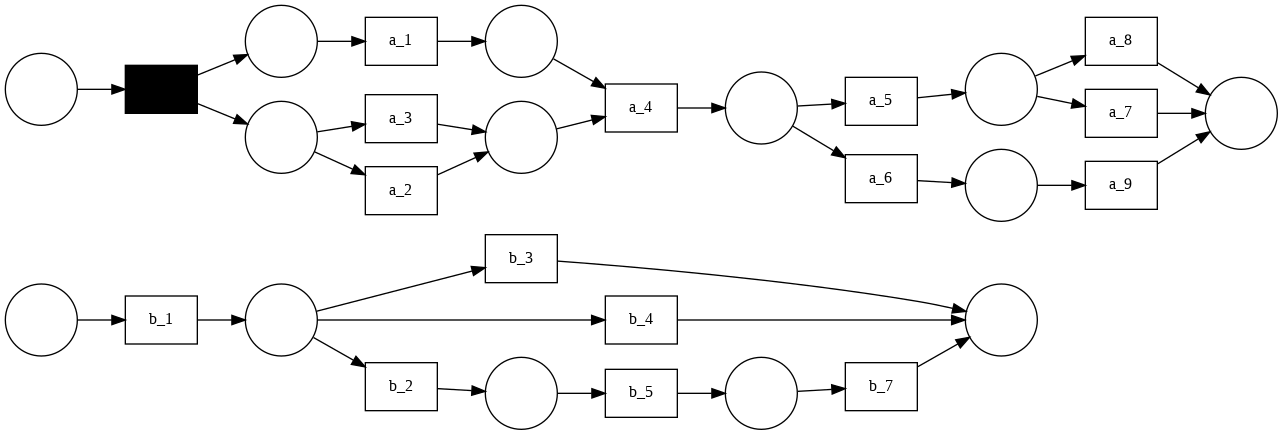

In [ ]:
pm.view_petri_net(petri_net_ind)

## SC ~= 0

In [ ]:
matr = [
    [1, 0, 0, 0],
    [-1, 0, 1, 0],
    [0, 1, -1, 0],
    [0, -1, 0, 1],
    [0, 0, 0, -1],
]
trans_labels = ['a_1', 'a_2', 'b_1', 'b_2']
trans_names = [f't_{i}' for i in range(4)]
places = [f'p_{i}' for i in range(5)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)

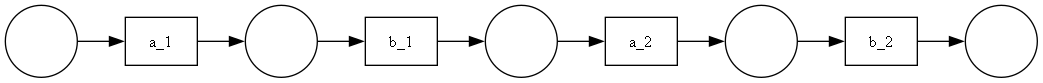

In [ ]:
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'b_1'}, 'a_2': {'b_2'}, 'b_1': {'a_2'}, 'b_2': set()}
gnc  =  0.0
lnc  =  0.25
blnc =  0.25


## 0 < SC < 1

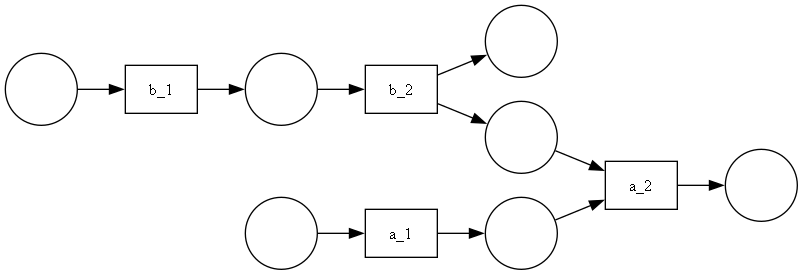

In [ ]:
matr = [
    [0, 0, 1, 0],
    [0, 0, -1, 1],
    [0, 0, 0, -1],
    [1, 0, 0, 0],
    [-1, 1, 0, 0],
    [0, -1, 0, 0],
    [0, 1, 0, -1],
]
trans_labels = ['a_1', 'a_2', 'b_1', 'b_2']
trans_names = [f't_{i}' for i in range(4)]
places = [f'p_{i}' for i in range(7)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'a_2'}, 'b_1': {'b_2'}, 'b_2': {'a_2'}, 'a_2': set()}
gnc  =  0.6666666666666667
lnc  =  0.75
blnc =  0.75


## SC ~= 1

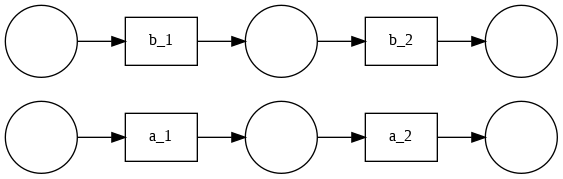

In [ ]:
matr = [
    [0, 0, 1, 0],
    [0, 0, -1, 1],
    [0, 0, 0, -1],
    [1, 0, 0, 0],
    [-1, 1, 0, 0],
    [0, -1, 0, 0],
]

trans_labels = ['a_1', 'a_2', 'b_1', 'b_2']
trans_names = [f't_{i}' for i in range(4)]
places = [f'p_{i}' for i in range(6)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'a_2'}, 'a_2': set(), 'b_1': {'b_2'}, 'b_2': set()}
gnc  =  1.0
lnc  =  1.0
blnc =  1.0


In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'c_1', 'b_1'}, 'c_1': set(), 'b_1': {'d_1'}, 'd_1': {'c_1'}}
gnc  =  0.0
lnc  =  0.25
blnc =  0.25
